## Part 1: IMPORT LIBRARIES ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('rainbow')

## PART 2: IMPORT DATASET ##

In [2]:
dailyActivity_df = pd.read_csv('dailyActivity_merged.csv')
dailyActivity_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [3]:
sleep_df = pd.read_csv('sleepDay_merged.csv')
sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [4]:
fitbit_df = pd.read_csv('fitbit_df.csv')
fitbit_df.head()

,SedentaryMinutes,TotalSteps,TotalMinutesAsleep,TotalTimeInBed,Calories
0,728,13162,327,346,1985
1,776,10735,384,407,1797
2,726,9762,412,442,1745
3,773,12669,340,367,1863
4,539,9705,700,712,1728


## Part 3: PREPARE DATA ##

Modify the date format and calculate the day of week

In [5]:
dailyActivity_df['ActivityDate'] = pd.to_datetime(dailyActivity_df['ActivityDate']).dt.date.astype('datetime64[ns]')
dailyActivity_df['Dow'] = dailyActivity_df['ActivityDate'].dt.strftime('%w')
dailyActivity_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Dow
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,2
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,3
2,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,4
3,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,5
4,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,6


In [6]:
sleep_df['SleepDay'] = pd.to_datetime(sleep_df['SleepDay'], errors='coerce')
sleep_df['Dow'] = sleep_df['SleepDay'].dt.strftime('%w')
sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,Dow
0,1503960366,2016-04-12,1,327,346,2
1,1503960366,2016-04-13,2,384,407,3
2,1503960366,2016-04-15,1,412,442,5
3,1503960366,2016-04-16,2,340,367,6
4,1503960366,2016-04-17,1,700,712,0


In [38]:
print("Different users:",dailyActivity_df['Id'].nunique())

Different users: 33


In [8]:
# Average Calories, Steps and Distance by Id and by day of the week
avg_Calories = round(dailyActivity_df.groupby(['Id', 'Dow'])['Calories'].mean(),2)
avg_TotalSteps = round( dailyActivity_df.groupby(['Id', 'Dow'])['TotalSteps'].mean(),2)
avg_TotalDistance = round(dailyActivity_df.groupby(['Id', 'Dow'])['TotalDistance'].mean(),2)

activity_dist ={'avg_Calories': avg_Calories,'avg_TotalSteps':avg_TotalSteps,'avg_TotalDistance': avg_TotalDistance}
activity_dist = pd.DataFrame(activity_dist)
activity_dist = activity_dist.reset_index(drop=False)
activity_dist

,Id,Dow,avg_Calories,avg_TotalSteps,avg_TotalDistance
0,1503960366,0,1769.00,10101.50,6.57
1,1503960366,1,1939.25,13780.75,8.96
2,1503960366,2,1967.80,13946.60,8.92
3,1503960366,3,1868.80,12656.60,8.23
4,1503960366,4,1481.60,9500.60,6.10
...,...,...,...,...,...
223,8877689391,2,3221.20,14924.60,12.52
224,8877689391,3,3672.40,19705.40,16.84
225,8877689391,4,3082.60,15503.00,12.94
226,8877689391,5,3518.50,15785.00,12.55


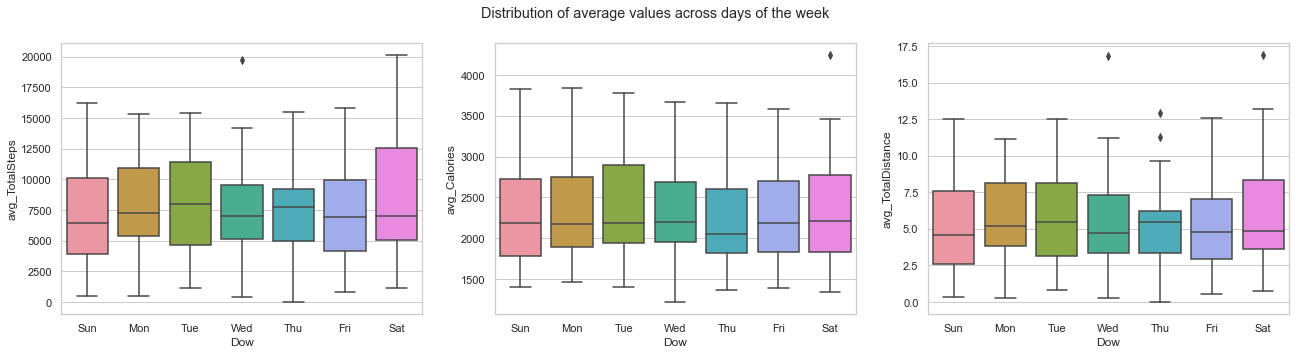

In [9]:
# Plot to show if users' activity is related to the day of the week
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')

sns.boxplot(x="Dow", y="avg_TotalSteps", data=activity_dist, ax=axes[0]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="Dow", y="avg_Calories", data=activity_dist, ax=axes[1]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="Dow", y="avg_TotalDistance", data=activity_dist, ax=axes[2]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);

Intercept: 1665.7426768758332
Slope: [0.08351327]


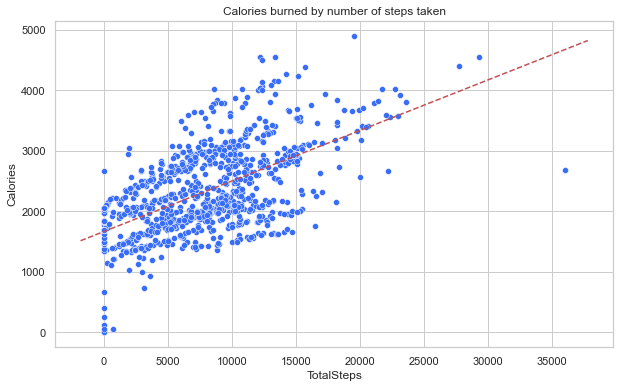

In [10]:
# Fit a line for full daily activity and get intercept and slope 
X = dailyActivity_df['TotalSteps'].values.reshape((-1, 1))
y = dailyActivity_df['Calories'].values

model = LinearRegression()
model.fit(X, y)

print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

sns.scatterplot(data = dailyActivity_df, x = 'TotalSteps', y = 'Calories')
plt.title('Calories burned by number of steps taken')
    
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = model.intercept_ + model.coef_ * x_vals
plt.plot(x_vals, y_vals, color= 'r', ls = '--')

As we usually think, the number of calories burned in a day increases as the user takes more steps. And we have an additional finding, by linear regression we can get a regression line, the intercept of the regression line represents the number of calories burned without any steps in a day, this number corresponds to the body's basal metabolic rate.

<AxesSubplot:xlabel='TotalMinutesAsleep', ylabel='SedentaryMinutes'>

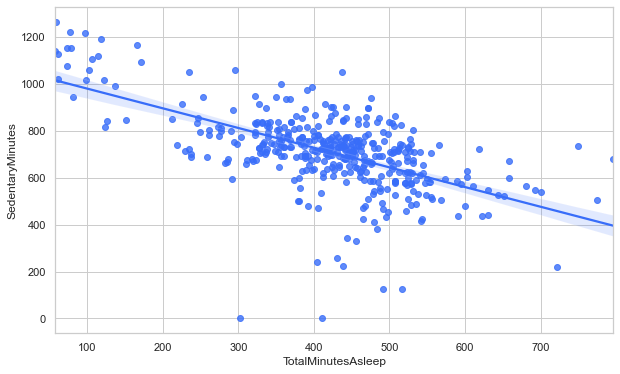

In [11]:
# Plot showing the relationship between sleep time and sedentary time
sns.regplot(data = fitbit_df,
               x = 'TotalMinutesAsleep',
               y = 'SedentaryMinutes')

From this image we find that the relationship between sedentary time and sleep time is inversely proportional, that is, users who sleep longer are also more active during the day.

From analyzing the daily activities of 33 users, we came to some interesting conclusions:

1. There is no significant difference in user activity on different days of the week.

2. If the goal is to burn some calories, we find a linear relationship between the steps taken and the calories burned. Therefore, we can use the number of steps taken as a parameter of the fitting model.

3. In terms of sleep habits, with the increase of sleep time, sedentary time is significantly reduced, and daytime activity increases, which also increases calorie consumption. Therefore, sleep time and sedentary time are also included in the parameters of the fitting model. 

## PART 4: SPLIT DATASET ##

Through the above analysis, we integrated the data of the two existing datasets, and extracted SedentaryMinutes, TotalSteps, TotalMinutesAsleep, TotalTimeInBed as four factors affecting calorie consumption to build the new dataset for our evaluation model.

In [12]:
fitbit_df.head()

,SedentaryMinutes,TotalSteps,TotalMinutesAsleep,TotalTimeInBed,Calories
0,728,13162,327,346,1985
1,776,10735,384,407,1797
2,726,9762,412,442,1745
3,773,12669,340,367,1863
4,539,9705,700,712,1728


<AxesSubplot:>

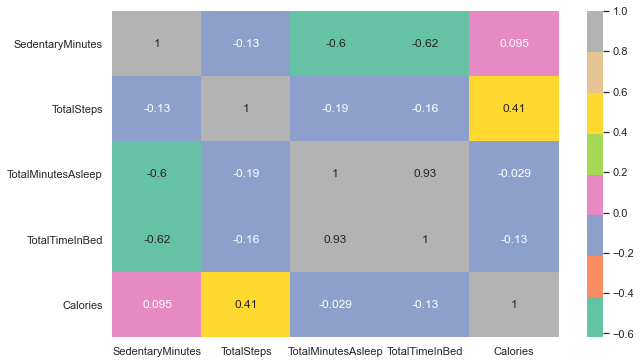

In [13]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='Set2', fmt='.2g')

We split the dataset so that the training set is 60% of the total dataset, and the validation set and test set are each 20% of the total dataset.

In [14]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1], 
                                                              fitbit_df['Calories'], 
                                                              test_size=0.2, 
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, 
                                                      test_size=0.25, random_state=42)

In [15]:
# Scale the data with object range of 0-1
scale = MinMaxScaler()

scale.fit_transform(X_train)
scale.transform(X_valid)
scale.transform(X_test)

array([[0.63330599, 0.36764383, 0.40785908, 0.37555556],
       [0.59557014, 0.45576408, 0.57859079, 0.48777778],
       [0.6997539 , 0.0528282 , 0.5799458 , 0.49111111],
       [0.56193601, 0.54379642, 0.44715447, 0.38444444],
       [0.90730107, 0.20476421, 0.06504065, 0.05222222],
       [0.61443806, 0.31455193, 0.38617886, 0.33222222],
       [0.39294504, 0.42082363, 0.73441734, 0.63888889],
       [0.59639048, 0.49997802, 0.49186992, 0.44      ],
       [0.54060705, 0.47061926, 0.49728997, 0.41555556],
       [0.6923708 , 0.60326111, 0.09214092, 0.08444444],
       [0.3388023 , 0.35990858, 0.57181572, 0.53888889],
       [0.5561936 , 0.36171054, 0.59891599, 0.55111111],
       [0.62674323, 0.23829825, 0.47425474, 0.43222222],
       [0.58736669, 0.30769569, 0.61382114, 0.53555556],
       [0.47087777, 0.40047466, 0.63821138, 0.55222222],
       [0.73420837, 0.08996616, 0.44715447, 0.40333333],
       [0.43478261, 0.28774228, 0.6504065 , 0.55444444],
       [0.47497949, 0.8581286 ,

## PART 5: SELECT MACHINE LEARNING MODELS ##

We establish baseline scores based on the performance of a model which predicts the mean everytime. The baseline is useful to assess whether the models we are going to train are actually 'learning' anything from the data.

In [16]:
# Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
base_MAE = mean_absolute_error(y_valid, baseline_y)
base_MSE = mean_squared_error(y_valid, baseline_y)
base_R2 = r2_score(y_valid, baseline_y)
base_errors = abs(baseline_y - y_valid)
base_ACCURACY = 100 - 100 * np.mean(base_errors / y_valid)
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_MAE))
print('Mean Squared Error: {:0.4f}.'.format(base_MSE))
print('R^2 Score = {:0.4f}.'.format(base_R2))
print('Accuracy = {:0.2f}%.'.format(base_ACCURACY))

Model Performance
Mean Absolute Error: 649.0120.
Mean Squared Error: 650005.8072.
R^2 Score = -0.0292.
Accuracy = 72.74%.


In [17]:
# Define a function with the same evaluation criteria as baseline.
def score(model, test_features, test_labels):
    predictions = model.predict(test_features)
    MAE = mean_absolute_error(test_labels, predictions)
    MSE = mean_squared_error(test_labels, predictions)
    R2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    ACCURACY = 100 - 100 * np.mean(errors / test_labels)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(MAE))
    print('Mean Squared Error: {:0.4f}.'.format(MSE))
    print('R^2 Score = {:0.4f}.'.format(R2))
    print('Accuracy = {:0.2f}%.'.format(ACCURACY))
    return R2, ACCURACY

### SVM ###

In [18]:
svm = SVC(kernel='rbf', random_state=42, gamma = 'scale',max_iter=500, C=1.0, probability = True)
svm = svm.fit(X_train , y_train)
SVM_R2, SVM_Accuracy = score(svm, X_valid, y_valid)

Model Performance
Mean Absolute Error: 928.2530.
Mean Squared Error: 1420250.0361.
R^2 Score = -1.2487.
Accuracy = 55.02%.


### Logistic Regression ###

In [19]:
logr = LogisticRegression()
logr = logr.fit(X_train,y_train)
Logistic_R2, Logistic_Accuracy = score(logr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 610.0843.
Mean Squared Error: 750975.8193.
R^2 Score = -0.1890.
Accuracy = 72.92%.


D:\Anaconda\Setup\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### AdaBoost ###

In [20]:
adab_regressor=ensemble.AdaBoostRegressor()
adab=adab_regressor.fit(X_train,y_train)
AdaBoost_R2, AdaBoost_Accuracy = score(adab, X_valid, y_valid)

Model Performance
Mean Absolute Error: 598.2490.
Mean Squared Error: 504676.0673.
R^2 Score = 0.2009.
Accuracy = 72.32%.


### Gradient Boosting ###

In [21]:
gbdt_regressor = ensemble.GradientBoostingRegressor()
gbdt = gbdt_regressor.fit(X_train, y_train) 
Gradient_R2, Gradient_Accuracy = score(gbdt, X_valid, y_valid)

Model Performance
Mean Absolute Error: 538.6777.
Mean Squared Error: 452900.1661.
R^2 Score = 0.2829.
Accuracy = 76.01%.


### Multiple Linear Regression ###

In [22]:
mlr_regressor = LinearRegression()
mlr = mlr_regressor.fit(X_train, y_train)
Multiple_Linear_R2, Multiple_Linear_Accuracy = score(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 571.5923.
Mean Squared Error: 461353.1211.
R^2 Score = 0.2695.
Accuracy = 74.79%.


### Random Forest ###

In [23]:
rf_regressor = RandomForestRegressor(random_state=42)
rf = rf_regressor.fit(X_train, y_train)
Random_Forest_R2, Random_Forest_Accuracy = score(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 506.9816.
Mean Squared Error: 407747.2590.
R^2 Score = 0.3544.
Accuracy = 77.49%.


### Extreme Gradient Boosting ###

In [24]:
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)
Extreme_Gradient_R2, Extreme_Gradient_Accuracy = score(xgb, X_valid, y_valid)

Model Performance
Mean Absolute Error: 499.4119.
Mean Squared Error: 419972.2894.
R^2 Score = 0.3350.
Accuracy = 78.23%.


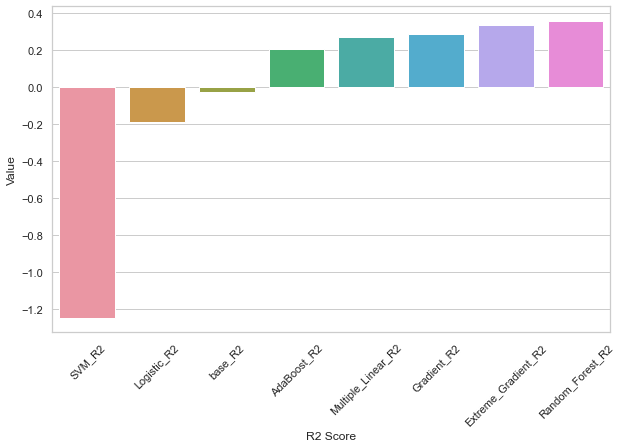

In [25]:
# The plot compares the R2 values of the various machine learning models
R2 = pd.DataFrame([['base_R2', base_R2],['SVM_R2', SVM_R2],['Logistic_R2', Logistic_R2],
                   ['AdaBoost_R2', AdaBoost_R2], ['Gradient_R2', Gradient_R2],
                   ['Multiple_Linear_R2', Multiple_Linear_R2],['Random_Forest_R2', Random_Forest_R2],
                   ['Extreme_Gradient_R2',Extreme_Gradient_R2]],columns = ['R2 Score','Value'])
 
sns.barplot(data = R2,
            x = 'R2 Score', y = 'Value',
            order=R2.sort_values('Value',ascending = True)['R2 Score'])
plt.xticks(rotation=45);

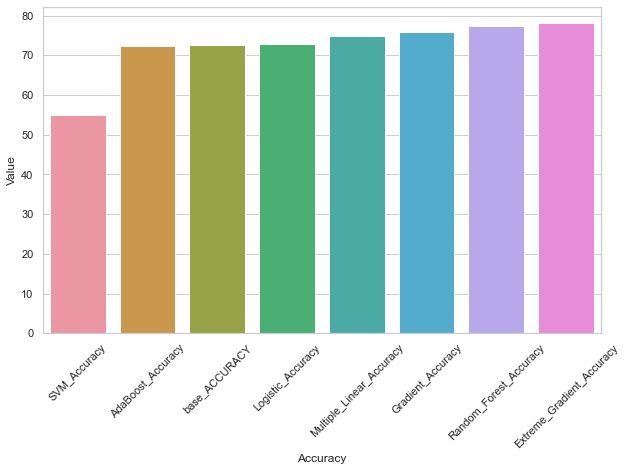

In [26]:
# The plot compares the accuracy values of each machine learning model
Accuracy = pd.DataFrame([['base_ACCURACY', base_ACCURACY],['SVM_Accuracy', SVM_Accuracy],['Logistic_Accuracy', Logistic_Accuracy],
                   ['AdaBoost_Accuracy', AdaBoost_Accuracy], ['Gradient_Accuracy', Gradient_Accuracy],
                   ['Multiple_Linear_Accuracy', Multiple_Linear_Accuracy],['Random_Forest_Accuracy', Random_Forest_Accuracy],
                   ['Extreme_Gradient_Accuracy',Extreme_Gradient_Accuracy]],columns = ['Accuracy','Value'])
 
sns.barplot(data = Accuracy,
            x = 'Accuracy', y = 'Value',
            order=Accuracy.sort_values('Value',ascending = True)['Accuracy'])
plt.xticks(rotation=45);

From the above two figures, we can see that the performances of the SVM, logistic regressionand and AdaBoost models are similar to the baseline, or even worse than the baseline. Therefore, we believe that these three models are not suitable for our dataset. So the remaining four models with better performances are used for further analysis.

## PART 6: CROSS-VALIDATION ##

In [27]:
# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    maes = []
    mses = []
    r2s = []
    accs = []
    cv_accuracies = pd.DataFrame()
  
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['MAE', 'MSE', 'R2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

In [28]:
# Put the models in a list to be used for Cross-Validation
models = [gbdt_regressor, mlr_regressor, rf_regressor, xgb_regressor]

# Run the Cross-Validation comparison with the models used in this analysis
cv_accuracies, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

arr1 = cv_accuracies.values
cv_accuracies

,GradientBoostingRegressor(),LinearRegression(),RandomForestRegressor(random_state=42),"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=42,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None)"
MAE,492.5556,523.9734,471.8517,482.7019
MSE,392842.1921,410459.2050,371613.2164,406833.3769
R2,0.3066,0.2813,0.3468,0.2825
Accuracy,79.6111,78.3106,80.4681,80.0190


From the above table, we can see that after cross-validation, the performance of the existing four models has all become better. Since the models of random forest and XGBoost perform better, we choose these two models for further optimization.

## PART 7: PARAMETERS HYPERTUNING ##

### Set hyperparameters possibilities for tuning Random Forest ###

In [29]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]

# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['mse', 'mae']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

In [30]:
# Tune the Random Forest Model
rf_random = RandomizedSearchCV(estimator = rf_regressor, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


D:\Anaconda\Setup\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mae', max_depth=15, max_features='log2',
                      min_impurity_decrease=0.05, min_samples_split=3,
                      n_estimators=200, random_state=42)

### Set hyperparameters possibilities for tuning XGBoost ###

In [31]:
# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

In [32]:
# Tune the XGBoost Model
xgb_random = RandomizedSearchCV(estimator = xgb_regressor, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train_temp, y_train_temp)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


D:\Anaconda\Setup\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
117 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\Setup\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\Setup\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "D:\Anaconda\Setup\lib\site-packages\xgboost\sklearn.py", line 789, in fit
    self._Booster = train(
  File "D:\Anaconda\Setup\lib\site-packages\xgboost\training.py", line 188, in train
    bst = _train_intern

{'tree_method': 'approx',
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 18,
 'gamma': 0,
 'eta': 0.30000000000000004}

### PART 8: FINAL MODEL EVALUATION ###

In [33]:
# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 200,
                                 min_samples_split = 3,
                                 min_impurity_decrease = 0.05,
                                 max_features = 'log2',
                                 max_depth = 15,
                                 criterion = 'mae',
                                 bootstrap = True,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'approx',
                         objective = 'reg:squarederror',
                         n_estimators = 80,
                         min_child_weight = 4,
                         max_depth = 12,
                         gamma = 0,
                         eta = 0.1,
                         random_state = 42)

rf_final.fit(X_train_temp, y_train_temp)
xgb_final.fit(X_train_temp, y_train_temp)

D:\Anaconda\Setup\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=12, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=80, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [34]:
# Calculate the parameters of the final random forest
rf_predictions = rf_final.predict(X_train_temp)
rf_mae = round(mean_absolute_error(y_train_temp, rf_predictions), 4)
rf_mse = round(mean_squared_error(y_train_temp, rf_predictions), 4)
rf_r2 = round(r2_score(y_train_temp, rf_predictions), 4)
rf_errors = abs(rf_predictions - y_train_temp)
rf_mape = 100 * np.mean(rf_errors / y_train_temp)
rf_accuracy = round(100 - rf_mape, 4)

# Calculate the parameters of the final XGB
xgb_predictions = xgb_final.predict(X_train_temp)
xgb_mae = round(mean_absolute_error(y_train_temp, xgb_predictions), 4)
xgb_mse = round(mean_squared_error(y_train_temp, xgb_predictions), 4)
xgb_r2 = round(r2_score(y_train_temp, xgb_predictions), 4)
xgb_errors = abs(xgb_predictions - y_train_temp)
xgb_mape = 100 * np.mean(xgb_errors / y_train_temp)
xgb_accuracy = round(100 - xgb_mape, 4)

final_score=pd.DataFrame(([rf_mae,xgb_mae],[rf_mse,xgb_mse],[rf_r2,xgb_r2],[rf_accuracy,xgb_accuracy]),columns=['Random_Forest_Regressor','XGB_Regressor'],index=['MAE', 'MSE', 'R2', 'Accuracy'])
final_score

,Random_Forest_Regressor,XGB_Regressor
MAE,195.5531,82.1441
MSE,65169.7779,12490.7631
R2,0.8861,0.9782
Accuracy,91.2154,96.3895


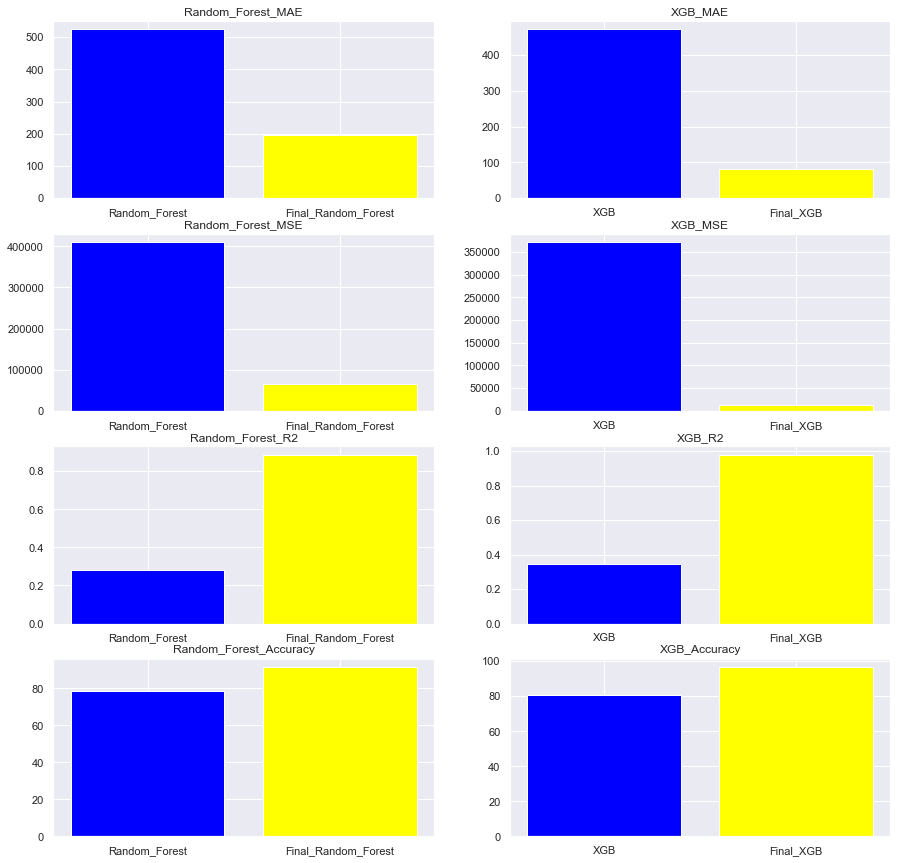

In [35]:
# The plot shows the changes of the random forest and XGBoost models before and after optimization
sns.set(rc={'figure.figsize': (15, 15)})
plt.figure(1)
plt.subplot(421)
plt.bar('Random_Forest',arr1[0][1], color="blue")
plt.bar('Final_Random_Forest',rf_mae, color="yellow")
plt.title("Random_Forest_MAE")

plt.subplot(423)
plt.bar('Random_Forest',arr1[1][1], color="blue")
plt.bar('Final_Random_Forest',rf_mse, color="yellow")
plt.title("Random_Forest_MSE")

plt.subplot(425)
plt.bar('Random_Forest',arr1[2][1], color="blue")
plt.bar('Final_Random_Forest',rf_r2, color="yellow")
plt.title("Random_Forest_R2")

plt.subplot(427)
plt.bar('Random_Forest',arr1[3][1], color="blue")
plt.bar('Final_Random_Forest',rf_accuracy, color="yellow")
plt.title("Random_Forest_Accuracy")

plt.subplot(422)
plt.bar('XGB',arr1[0][2], color="blue")
plt.bar('Final_XGB',xgb_mae, color="yellow")
plt.title("XGB_MAE")

plt.subplot(424)
plt.bar('XGB',arr1[1][2], color="blue")
plt.bar('Final_XGB',xgb_mse, color="yellow")
plt.title("XGB_MSE")

plt.subplot(426)
plt.bar('XGB',arr1[2][2], color="blue")
plt.bar('Final_XGB',xgb_r2, color="yellow")
plt.title("XGB_R2")

plt.subplot(428)
plt.bar('XGB',arr1[3][2], color="blue")
plt.bar('Final_XGB',xgb_accuracy, color="yellow")
plt.title("XGB_Accuracy")

plt.show()

From the above table and images, we can see that the performance of the Random Forest and XGBoost models after hyperparameter tuning and optimization has been further improved. Especially the optimized XGBoost model, which has excellent R2 score and accuracy, we can use this model to predict the value of calories consumed by people.